In [1]:
import BlackScholes as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import risk_free_rates as rf
import implied_q as iq
import time
import variance_curve as vc

from rbergomi import rBergomi
from matplotlib import cm

In [2]:
# Read the dataset

S0 = 4017.8

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = S0 * moneyness / 100

maturities = maturities[1:11]
IV = IV[1:11,:]

#rho, H, eta = (-0.8922447886261287, 0.0818355558094449, 1.9430944338216567)

rho, H, eta = (-0.854017216003975, 0.06688238300991937, 1.9707188371581137)

In [3]:
def price(S, K, r, q, T):
    n = len(K)
    p = np.zeros(n)
    for i in range(n):
        p[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
    return p

In [4]:
t = time.time()

nr = len(maturities); nc = len(K);
N = 15000; n = 1000;
steps = np.ceil(n*maturities).astype(int)
T = maturities[-1]
np.random.seed(0)    
iv = np.zeros([nr,nc])

alpha = H - 0.5
    
rB = rBergomi(n, N, T, alpha)
xi = vc.variance_curve(rB.t[0])
dW1 = rB.dW1(); dW2 = rB.dW2();    
Ya = rB.Y(dW1)
dZ = rB.dZ(dW1, dW2, rho)
V = rB.V(Ya, xi, eta)
    
S = rB.global_S(V, dZ, S0, steps)
    
for i in range(nr):
    aux_T = maturities[i]
    r = rf.r(aux_T); q = iq.q(aux_T);
    P = price(S[i,:], K, r, q, aux_T)
    iv[i,:] = bs.BSImpliedVol(S0, K, aux_T, r, q, P, Option_type = 1, toll = 1e-5)
    
print(f'Function execution time: {time.time()-t: .0f} s')

Function execution time:  2 s


In [5]:
print(f"Relative mean error on IV: {np.mean(abs(IV-iv)/IV)*100:.4f}%")

Relative mean error on IV: 3.6005%


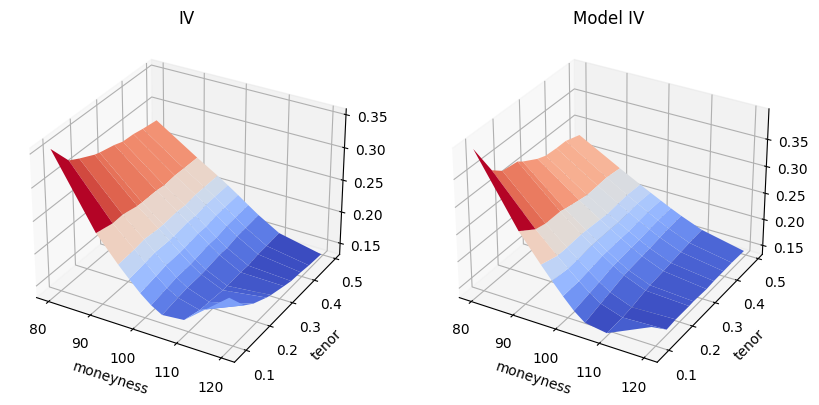

In [6]:
#%matplotlib notebook

mesh_x, mesh_y = np.meshgrid(moneyness,maturities)

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(5)
ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV, cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('moneyness')
ax1.set_ylabel('tenor')
ax1.set_title('IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, iv, cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('moneyness')
ax2.set_ylabel('tenor')
ax2.set_title('Model IV')

plt.show()